In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import optuna

In [4]:
df = pd.read_csv('Titanic-Dataset.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
target_col = 'Survived'
df.isnull().any()
df = df.dropna(subset=target_col, axis=0)

In [7]:
X = df.drop(target_col, axis=1)
y = pd.DataFrame(df[target_col])

cat_cols = list(X.dtypes[X.dtypes=='object'].keys())
num_cols = list(X.dtypes[X.dtypes=='number'].keys())


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)
X_train[cat_cols] = X_train[cat_cols].apply(lambda col: col.astype('category'))
X_valid[cat_cols] = X_valid[cat_cols].apply(lambda col: col.astype('category'))


sample_row = X.loc[0].to_dict()

There is a higher chance of survival of Pclass 1 than 2 and 3. Also, women and children have a higher chance of survival.

([0, 1], [Text(0, 0, '0'), Text(1, 0, '1')])

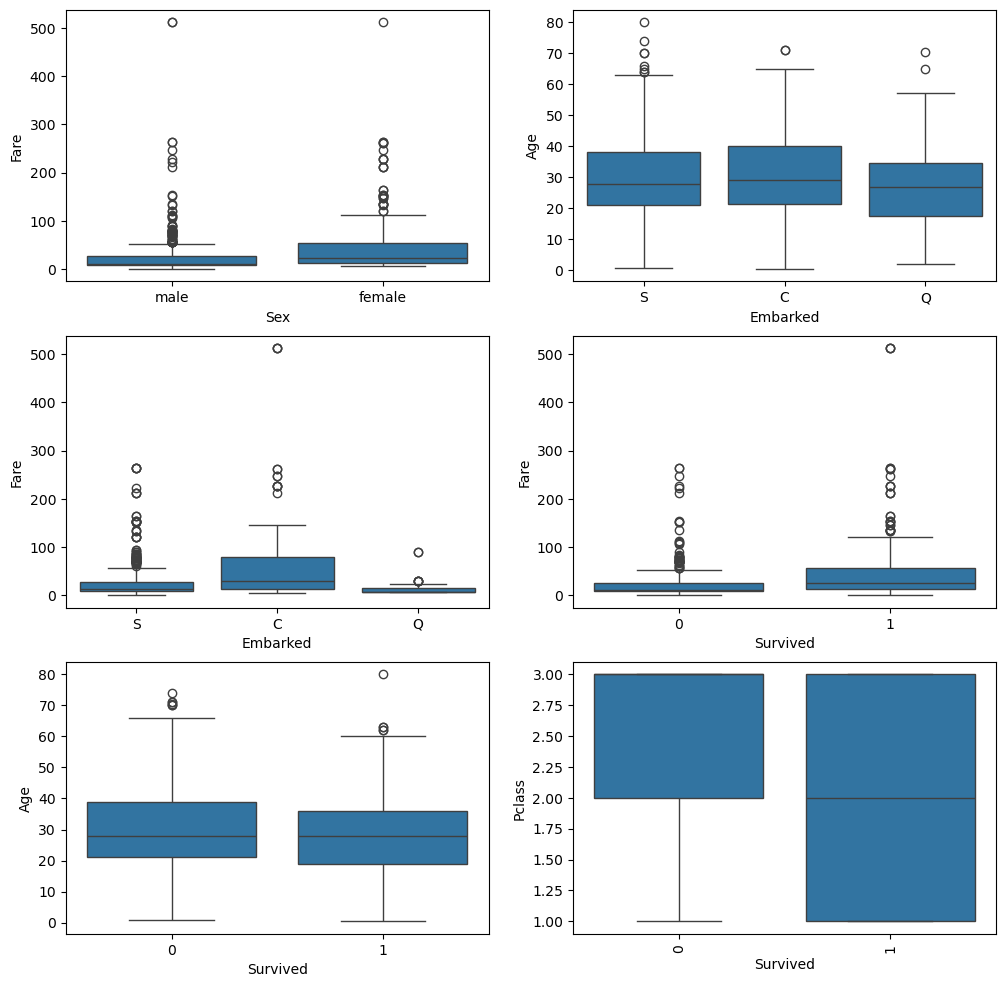

In [8]:
# Create a figure with a grid of subplots (4 rows, 2 columns)
f, ax = plt.subplots(3, 2, figsize=(12, 12))  # Adjust figsize as needed

# First box plot for 'Sex' vs 'Fare'
sns.boxplot(x='Sex', y='Fare', data=df, ax=ax[0][0])
# ax[0][0].set_title('Fare by Sex')

# Second box plot for 'Ticket' vs 'Fare'
sns.boxplot(x='Embarked', y='Age', data=df, ax=ax[0][1])
# ax[0][1].set_title('Embarked by Age')

sns.boxplot(x='Embarked', y='Fare', data=df, ax=ax[1][0])
# ax[1][0].set_title('Fare by Embarked')

sns.boxplot(x='Survived', y='Fare', data=df, ax=ax[1][1])
# ax[1][0].set_title('Fare by Ticket')

sns.boxplot(x='Survived', y='Age', data=df, ax=ax[2][0])
# ax[2][0].set_title('Fare by Ticket')

sns.boxplot(x='Survived', y='Pclass', data=df, ax=ax[2][1])
# ax[2][1].set_title('Fare by Ticket')

plt.xticks(rotation=90)

<Axes: xlabel='count', ylabel='Embarked'>

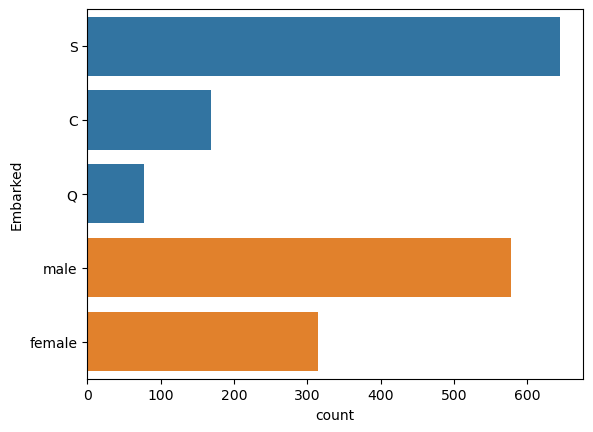

In [9]:
sns.countplot(df['Embarked'])
sns.countplot(df['Sex'])

<Axes: xlabel='Survived', ylabel='Fare'>

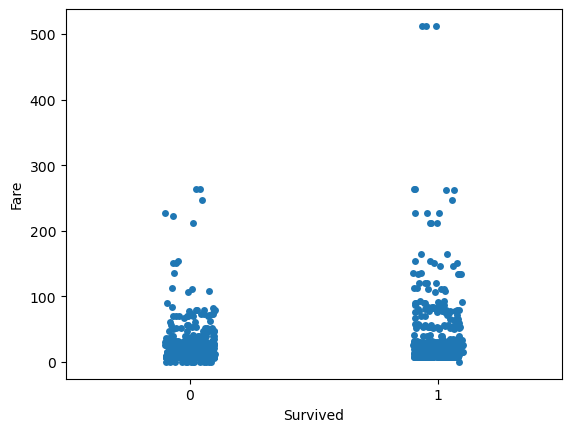

In [10]:
sns.stripplot(x='Survived', y='Fare', data=df)

In [11]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [12]:
model = LGBMClassifier()
model.fit(X_train, y_train, categorical_feature=cat_cols)
preds = model.predict(X_valid)

print(f'accuracy_score: {accuracy_score(y_valid, preds)}')

[LightGBM] [Info] Number of positive: 242, number of negative: 381
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 432
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.388443 -> initscore=-0.453862
[LightGBM] [Info] Start training from score -0.453862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


              precision    recall  f1-score   support

           0       0.83      0.89      0.86       168
           1       0.79      0.70      0.74       100

    accuracy                           0.82       268
   macro avg       0.81      0.79      0.80       268
weighted avg       0.82      0.82      0.81       268



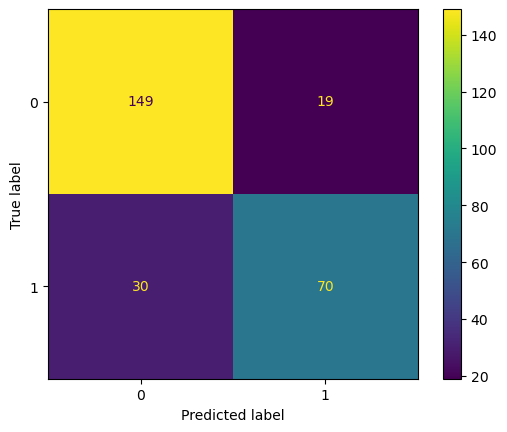

In [13]:
cm = confusion_matrix(y_valid, preds)
ConfusionMatrixDisplay(cm).plot()
print(classification_report(y_valid, preds))

# Optuna

In [14]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 20, 400)
    clf = LGBMClassifier(n_estimators=n_estimators)
    clf.fit(X_train, y_train)
    return clf.score(X_valid, y_valid)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3)

n_estimators = study.best_trial.params['n_estimators']
clf = LGBMClassifier(n_estimators=n_estimators)
clf.fit(X_train, y_train)


[I 2024-10-11 15:22:26,850] A new study created in memory with name: no-name-3941230c-7434-472d-a35e-061a0d69cb60


[LightGBM] [Info] Number of positive: 242, number of negative: 381
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 432
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.388443 -> initscore=-0.453862
[LightGBM] [Info] Start training from score -0.453862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
[I 2024-10-11 15:22:27,023] Trial 0 finished with value: 0.7985074626865671 and parameters: {'n_estimators': 229}. Best is trial 0 with value: 0.7985074626865671.
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-11 15:22:27,086] Trial 1 finished with value: 0.8208955223880597 and parameters: {'n_estimators': 80}. Best is trial 1 with value: 0.8208955223880597.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
[I 2024-10-11 15:22:27,168] Trial 2 finished with value: 0.8134328358208955 and parameters: {'n_estimators': 114}. Best is trial 1 with value: 0.8208955223880597.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


LGBMClassifier(n_estimators=80)

In [15]:
import pickle

with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [16]:
from typing import Optional
from pydantic import BaseModel, ValidationError

class Passenger(BaseModel):
    PassengerId: Optional[int] = None
    Pclass: Optional[int] = None
    Name: Optional[object] = None  # Use str instead of object
    Sex: Optional[object] = None  # Use str instead of object
    Age: Optional[float] = None
    SibSp: Optional[int] = None
    Parch: Optional[int] = None
    Ticket: Optional[object] = None  # Use str instead of object
    Fare: Optional[float] = None
    Cabin: Optional[object] = None  # Use str instead of object
    Embarked: Optional[object] = None  # Use str instead of object

with open('model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

print(sample_row)
passenger = Passenger(**sample_row)
inputs = pd.DataFrame([passenger.model_dump()])
inputs[cat_cols] = inputs[cat_cols].apply(lambda col: col.astype('category'))
pred = loaded_model.predict(inputs)[0]
pred

{'PassengerId': 1, 'Pclass': 3, 'Name': 'Braund, Mr. Owen Harris', 'Sex': 'male', 'Age': 22.0, 'SibSp': 1, 'Parch': 0, 'Ticket': 'A/5 21171', 'Fare': 7.25, 'Cabin': nan, 'Embarked': 'S'}


0

In [17]:
from flask import Flask, jsonify, request

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    try:
        passenger = Passenger(**request.json)
        inputs = pd.DataFrame([passenger.model_dump()])
        inputs[cat_cols] = inputs[cat_cols].apply(lambda col: col.astype('category'))
        pred = loaded_model.predict(inputs)[0]

        response = {
            'prediction': int(pred)
        }

        return jsonify(response), 200
    except ValueError as e:
        return jsonify(e.errors()), 400

if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [11/Oct/2024 15:22:40] "POST /predict HTTP/1.1" 200 -
